In [1]:
import deepchem as dc
from rdkit import Chem
from torch_geometric.data import Data, Batch
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, GraphNorm
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [3]:
# 1. Load QM9
tasks, datasets, _ = dc.molnet.load_qm9(featurizer='GraphConv')
train_dataset, _, _ = datasets
N = 50000

smiles_list = []
y_values = []
for i, (_, y, _, ids) in enumerate(train_dataset.iterbatches(batch_size=1, deterministic=True)):
    if i >= N:
        break
    smiles_list.append(ids[0])
    y_values.append(y[0][2])  # HOMO


In [5]:
# 2. Atom & Bond Features
def atom_features(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetTotalDegree(),
        atom.GetFormalCharge(),
        int(atom.GetHybridization()),
        int(atom.GetIsAromatic()),
        atom.GetTotalNumHs(includeNeighbors=True),
        atom.GetMass(),
        atom.GetExplicitValence(),
        atom.GetImplicitValence()
    ]

def bond_features(bond):
    return [
        int(bond.GetBondTypeAsDouble()),
        int(bond.GetIsAromatic())
    ]

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()

    x = torch.tensor([atom_features(a) for a in atoms], dtype=torch.float)
    edge_index = []
    for bond in bonds:
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)

graphs = [smiles_to_graph(s) for s in smiles_list]


In [7]:

# 3. Normalize HOMO
y_values = np.array(y_values)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_values.reshape(-1, 1)).flatten()

# 4. Dataset
from torch.utils.data import Dataset
class GraphDataset(Dataset):
    def __init__(self, graph_data):
        self.graph_data = graph_data
    def __len__(self):
        return len(self.graph_data)
    def __getitem__(self, idx):
        graph, target = self.graph_data[idx]
        graph.y = target
        return graph

data = [(g, torch.tensor([y], dtype=torch.float)) for g, y in zip(graphs, y_scaled)]
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
train_loader = DataLoader(GraphDataset(train_data), batch_size=32, shuffle=True)
val_loader = DataLoader(GraphDataset(val_data), batch_size=32)


In [9]:
# 5. GATConv-based GNN
class GNNEncoder(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=64):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels)
        self.gat2 = GATConv(hidden_channels, hidden_channels)
        self.gat3 = GATConv(hidden_channels, hidden_channels)
        self.norm = GraphNorm(hidden_channels)
        self.dropout = nn.Dropout(0.25)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.leaky_relu(self.gat1(x, edge_index))
        x = self.norm(x, batch)
        x = self.dropout(x)
        x = F.leaky_relu(self.gat2(x, edge_index))
        x = x + self.gat3(x, edge_index)  # residual
        x = global_mean_pool(x, batch)
        return x

# 6. Final Predictor
class HOMOPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = GNNEncoder()
        self.regressor = nn.Linear(64, 1)

    def forward(self, data):
        x = self.encoder(data)
        return self.regressor(x).view(-1)


In [13]:
# 7. Train
model = HOMOPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

print("\n Training GNN-only model...\n")
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        pred = model(batch)
        loss = loss_fn(pred, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:03d} | Loss: {total_loss / len(train_loader):.4f}")



 Training GNN-only model...

Epoch 001 | Loss: 1.0017
Epoch 002 | Loss: 0.9923
Epoch 003 | Loss: 0.9905
Epoch 004 | Loss: 0.9894
Epoch 005 | Loss: 0.9879
Epoch 006 | Loss: 0.9875
Epoch 007 | Loss: 0.9869
Epoch 008 | Loss: 0.9862
Epoch 009 | Loss: 0.9863
Epoch 010 | Loss: 0.9877
Epoch 011 | Loss: 0.9853
Epoch 012 | Loss: 0.9851
Epoch 013 | Loss: 0.9840
Epoch 014 | Loss: 0.9830
Epoch 015 | Loss: 0.9806
Epoch 016 | Loss: 0.9817
Epoch 017 | Loss: 0.9807
Epoch 018 | Loss: 0.9824
Epoch 019 | Loss: 0.9814
Epoch 020 | Loss: 0.9802
Epoch 021 | Loss: 0.9783
Epoch 022 | Loss: 0.9786
Epoch 023 | Loss: 0.9771
Epoch 024 | Loss: 0.9787
Epoch 025 | Loss: 0.9773
Epoch 026 | Loss: 0.9776
Epoch 027 | Loss: 0.9775
Epoch 028 | Loss: 0.9770
Epoch 029 | Loss: 0.9761
Epoch 030 | Loss: 0.9753
Epoch 031 | Loss: 0.9767
Epoch 032 | Loss: 0.9759
Epoch 033 | Loss: 0.9743
Epoch 034 | Loss: 0.9758
Epoch 035 | Loss: 0.9735
Epoch 036 | Loss: 0.9740
Epoch 037 | Loss: 0.9740
Epoch 038 | Loss: 0.9726
Epoch 039 | Loss: 0.

In [17]:
import random


 MAE: 0.6869
 RMSE: 0.8966
 R² Score: 0.0495


C:\Users\deep7\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


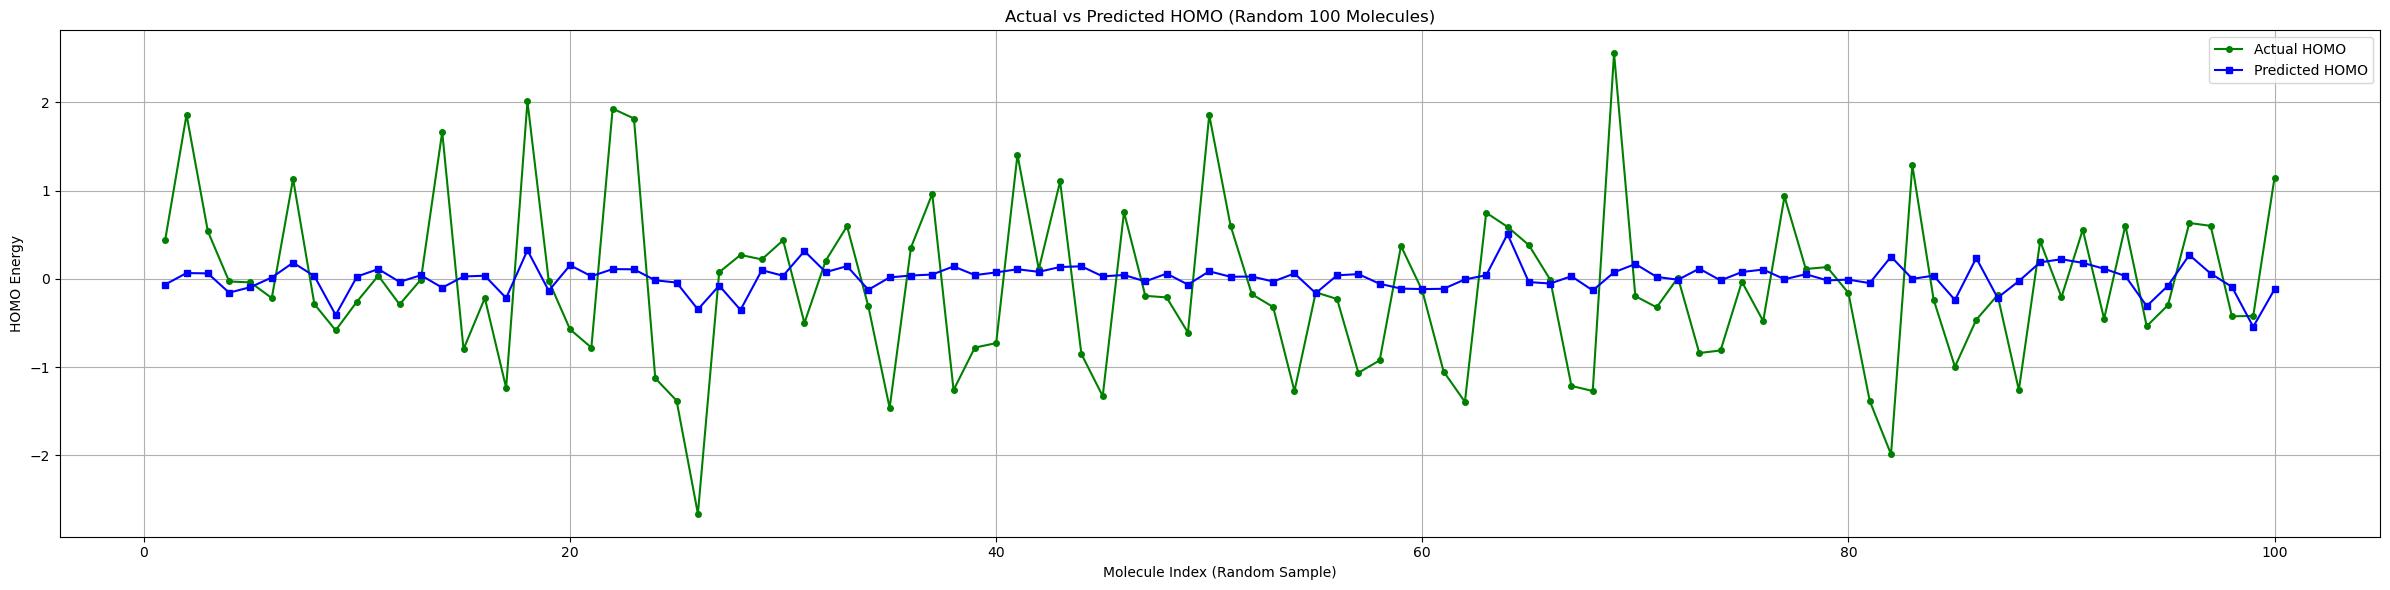

In [21]:
# Set model to evaluation mode
model.eval()

# 1. Pick 100 random indices
random_indices = random.sample(range(len(graphs)), 100)

# 2. Prepare actual and predicted values
actual_homo = [y_values[i] for i in random_indices]
predicted_homo = []

# 3. Predict HOMO for each random molecule
with torch.no_grad():
    for idx in random_indices:
        graph = graphs[idx]
        graph.y = torch.tensor([0.0])  # dummy value to prevent errors
        batch_data = Batch.from_data_list([graph])
        pred_scaled = model(batch_data)[0].item()
        pred = scaler_y.inverse_transform([[pred_scaled]])[0][0]
        predicted_homo.append(pred)

# 4. Compute Metrics
mae = mean_absolute_error(actual_homo, predicted_homo)
rmse = mean_squared_error(actual_homo, predicted_homo, squared=False)
r2 = r2_score(actual_homo, predicted_homo)


print(f"\n MAE: {mae:.4f}")
print(f" RMSE: {rmse:.4f}")
print(f" R² Score: {r2:.4f}")


# 5. Plot Actual vs Predicted for 100 molecules
plt.figure(figsize=(24, 6))
plt.plot(range(1, 101), actual_homo, label='Actual HOMO', marker='o', color='green', markersize=4)
plt.plot(range(1, 101), predicted_homo, label='Predicted HOMO', marker='s', color='blue', markersize=4)
plt.xlabel("Molecule Index (Random Sample)")
plt.ylabel("HOMO Energy")
plt.title("Actual vs Predicted HOMO (Random 100 Molecules)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
